In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

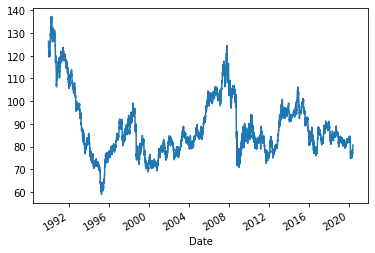

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot()

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Short term investment. As the graph is going downwards.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_HP = pd.DataFrame()
# Fetch data
cad_jpy_HP["Price"] = cad_jpy_df["Price"]
cad_jpy_HP["noise"] = cad_jpy_noise
cad_jpy_HP["trend"] = cad_jpy_trend
cad_jpy_HP.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

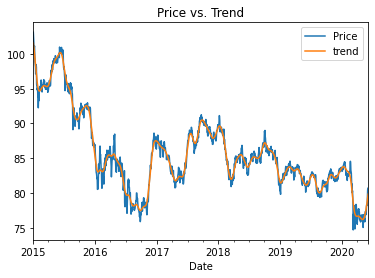

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_ERP = cad_jpy_HP.loc["2015-01-01" :, :]
cad_jpy_ERP = cad_jpy_ERP.drop(columns=["noise"])
cad_jpy_ERP.plot(title='Price vs. Trend')

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Same short-term. Anf JPY is getting stronger than CAD.

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

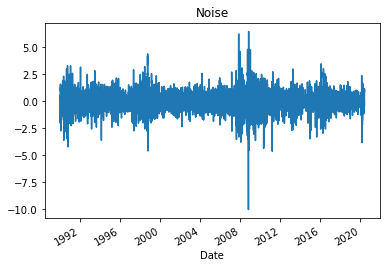

In [8]:
# Plot the Settle Noise
cad_jpy_noise.plot(title='Noise')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))

model_arma = sm.tsa.arima.ARIMA(returns.values, order=(2,1,1))

# Fit the model and assign it to a variable called results
results_arma = model_arma.fit()

In [11]:
# Output model summary results:
results_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -9756.104
Date:                Sat, 06 Aug 2022   AIC                          19520.207
Time:                        16:46:24   BIC                          19548.119
Sample:                             0   HQIC                         19529.765
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0304      0.007     -4.458      0.000      -0.044      -0.017
ar.L2         -0.0019      0.006     -0.303      0.762      -0.015       0.011
ma.L1         -1.0000      0.016    -60.839      0.000      -1.032      -0.968
sigma2         0.6856      0.013     51.749      0.000       0.660       0.712
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11627.62
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
results_arma.forecast(steps=5)

array([-0.00338375, -0.00220398, -0.00220917, -0.0022113 , -0.00221123])

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

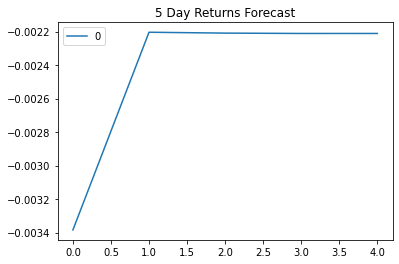

In [13]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results_arma.forecast(steps=5)).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** YOUR ANSWER HERE

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [14]:


# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(cad_jpy_df['Price'], order=(5, 1, 1))

results_arima = model_arima.fit()


/Users/tejaspatel/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tejaspatel/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tejaspatel/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7929
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.898
Date:                Sat, 06 Aug 2022   AIC                          17505.796
Time:                        16:46:28   BIC                          17554.643
Sample:                             0   HQIC                         17522.523
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.331      1.299      0.194      -0.219       1.080
ar.L2          0.0178      0.012      1.459      0.145      -0.006       0.042
ar.L3         -0.0118      0.009     -1.313      0.189      -0.029       0.006
ar.L4          0.0110      0.008      1.299      0.194      -0.006       0.028
ar.L5         -0.0191      0.007     -2.706      0.007      -0.033      -0.005
ma.L1         -0.4583      0.332     -1.380      0.167      -1.109       0.192
sigma2         0.5318      0.004    118.418      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9233.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/tejaspatel/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


<AxesSubplot:title={'center':'5 Day Future Price Forecast'}>

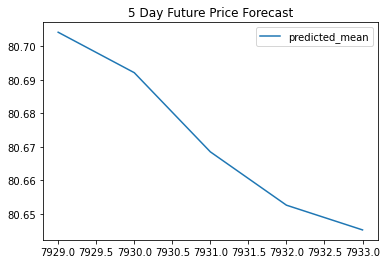

In [16]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results_arima.forecast(steps=5)).plot(title="5 Day Future Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The model forecast shows that the Japonese Yen will get stronger compared to CAD, it means that the Yen will increase in value

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [17]:
from arch import arch_model


In [18]:
# Estimate a GARCH model:
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_garch = model_garch.fit(disp="on")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 306850859.3384427
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838861417698
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11771.663036006626
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.31072801688
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.369930732108
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.112105819691
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027322298947
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.022077988246
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021067661106
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020797453917
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764880363
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.020764882265


In [24]:
# Summarize the model results
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sat, Aug 06 2022   Df Residuals:                     7928
Time:                        16:46:29   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [25]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [26]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results_garch.forecast(start=last_day, horizon=forecast_horizon)

In [27]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [28]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:>

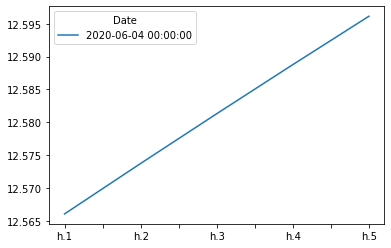

In [32]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** The model forecast shows that the volatility will increase in the near term

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

   * Based on this analysis, the YEN will get stronger, so it's a good investment oportunity

2. Is the risk of the yen expected to increase or decrease?
   * It is expected that the risk (volatility) will increase, so others factors should be addressed before investment

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * Based on this model, I'm not confident to use it because the model is not a good fit due the p > 0.05. Which should be p < 0.05 to be a good fit
Also, before trading the CAD/JPY always take into account Canada's and Japan's respective economic policies and unemployment rates, exports and imports statics and GDP growth